In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Define constants
IMAGE_SIZE = 416
BATCH_SIZE = 32
EPOCHS = 10
MAX_SAMPLES = 10000

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    labels = load_labels(path)[1:]

    h, w = img.shape[:2]
    
    return img, labels, w, h
    
def load_labels(path):
    path = path + ".cat"
    
    with open(path, 'r') as f:
        coordinates = f.readline()
        coordinates = str(coordinates).split(' ')[:-1]
    
    return list(map(int, coordinates))

def preprocess_image(image):
    x = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    x = x / 255.0
    return x

def preprocess_labels(labels, width, height):
    y = labels
    y[0:18:2] = list(map(lambda point: point / width, y[0:18:2])) # x
    y[1:18:2] = list(map(lambda point: point / height, y[1:18:2])) # y
    return y

def decode_labels(labels, width, height):
    labels[0:18:2] = labels[0:18:2] * width
    labels[1:18:2] = labels[1:18:2] * height
    return labels

def init_dataset(path, preprocess=False):
    root_path = path
    images = []
    labels = []
    counter = 0
    
    for root, _, files in os.walk(root_path):
        for file in files:
            if file.endswith('.jpg'):
                img, lbl, w, h = load_image(os.path.join(root, file))
                
                if preprocess:
                    img = preprocess_image(img)
                    lbl = preprocess_labels(lbl, w, h)
                images.append(img)
                labels.append(lbl)
                
                counter += 1
                if counter >= MAX_SAMPLES:
                    break
        if counter >= MAX_SAMPLES:
            break
    
    images = np.asarray(images)
    labels = np.asarray(labels)
    
    return images, labels.reshape(-1, 18)

def create_detection_head(inputs):
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    
    # Bounding box regression
    bbox = Conv2D(18, (1, 1), padding='same', activation='sigmoid')(x)
    bbox = GlobalAveragePooling2D()(bbox)
    
    # Class prediction
    class_pred = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)
    class_pred = GlobalAveragePooling2D()(class_pred)
    
    return bbox, class_pred

def build_model():
    resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    fpn = resnet.output

    # Build detection head
    bbox, class_pred = create_detection_head(fpn)
    
    # Define the model
    model = Model(inputs=resnet.input, outputs=[bbox, class_pred])
    
    return model

def show_results(img, labels):
    plt.imshow(img)
    plt.scatter(labels[0:18:2], labels[1:18:2], c='r')
    plt.show()

def image_data_generator(paths, batch_size=32, preprocess=False):
    while True:
        images = []
        labels = []
        counter = 0
        
        for path in paths:
            for root, _, files in os.walk(path):
                for file in files:
                    if file.endswith('.jpg'):
                        img, lbl, w, h = load_image(os.path.join(root, file))
                        
                        if preprocess:
                            img = preprocess_image(img)
                            lbl = preprocess_labels(lbl, w, h)
                        
                        images.append(img)
                        labels.append(lbl)
                        counter += 1
                        
                        if counter >= batch_size:
                            yield np.asarray(images), np.asarray(labels).reshape(-1, 18)
                            images = []
                            labels = []
                            counter = 0

train_paths = ['../input/cat-dataset/CAT_00/', '../input/cat-dataset/CAT_01/', '../input/cat-dataset/CAT_02/', '../input/cat-dataset/CAT_03/']

train_generator = image_data_generator(train_paths, batch_size=BATCH_SIZE, preprocess=True)

# Build and compile the model
model = build_model()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss=['mse', 'binary_crossentropy'], metrics=['accuracy', 'accuracy'])

# Train the model
model.fit(train_generator, steps_per_epoch=MAX_SAMPLES//BATCH_SIZE, epochs=EPOCHS)

# Save the model
model.save('cat_detector.h5')


2024-06-12 10:59:24.875047: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-12 10:59:24.875152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-12 10:59:25.045061: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 422, 422,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 208, 208,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 208, 208,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 208, 208,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 210, 210,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 104, 104,  │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 104, 104,  │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 104, 104,  │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 104, 104,  │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 104, 104,  │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 104, 104,  │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 104, 104,  │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 104, 104,  │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 104, 104,  │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 104, 104,  │      1,024 │ conv2_block1_3_c

 Total params: 28,312,467 (108.00 MB)

 Trainable params: 28,258,835 (107.80 MB)

 Non-trainable params: 53,632 (209.50 KB)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
2024-06-12 11:01:03.969868: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,416,416]{3,2,1,0}, f32[32,64,208,208]{3,2,1,0}), window={size=7x7 stride=2x2 pad=3_3x3_3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-12 11:01:04.300525: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.330850093s
Trying algorithm eng0{} for conv (f32[64,3,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,416,416]{3,2,1,0}, f32[32,64,208,208]{3,2,1,0})

312/312 ━━━━━━━━━━━━━━━━━━━━ 423s 994ms/step - global_average_pooling2d_accuracy: 0.5746 - loss: 0.0139
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 302s 969ms/step - global_average_pooling2d_accuracy: 0.7174 - loss: 0.0033
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 302s 968ms/step - global_average_pooling2d_accuracy: 0.7759 - loss: 0.0017
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 302s 967ms/step - global_average_pooling2d_accuracy: 0.8086 - loss: 8.8975e-04
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 303s 970ms/step - global_average_pooling2d_accuracy: 0.8243 - loss: 6.6789e-04
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 304s 973ms/step - global_average_pooling2d_accuracy: 0.8473 - loss: 4.4591e-04
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 303s 971ms/step - global_average_pooling2d_accuracy: 0.8692 - loss: 3.1379e-04
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 302s 968ms/step - global_average_pooling2d_accuracy: 0.8735 - loss: 3.1389e-04
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 303s 970ms/step - global_averag

# Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


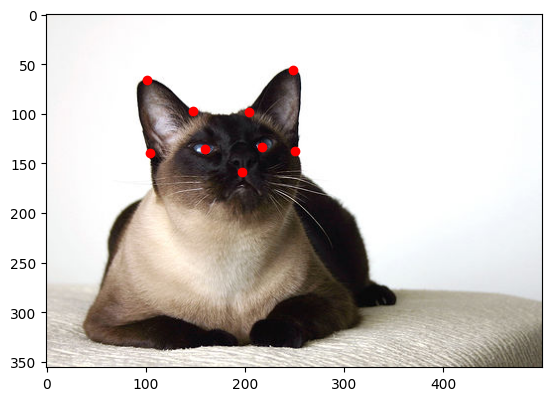

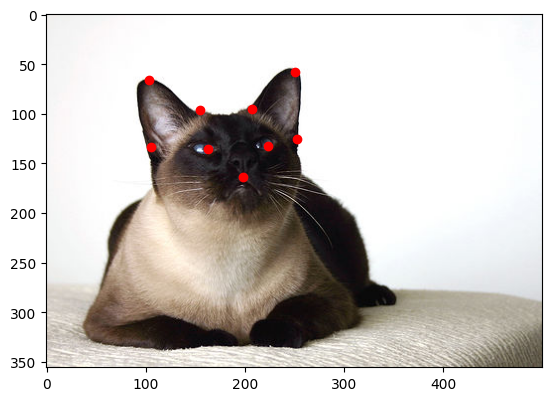

In [7]:

img, lbl, w, h = load_image('../input/cat-dataset/CAT_06/00001292_028.jpg')
image_preprocessed = preprocess_image(img)


bbox_pred, class_pred = model.predict(np.expand_dims(image_preprocessed, axis=0))
bbox_pred = decode_labels(bbox_pred.flatten(), w, h)


show_results(img, lbl)  
show_results(img, bbox_pred) 


def show_results(img, labels):
    plt.imshow(img)
    plt.scatter(labels[0:18:2], labels[1:18:2], c='r')
    plt.show()

In [8]:
print("Original Labels:", lbl)
print("Predicted Labels (Scaled):", bbox_pred)


Original Labels: [160, 135, 217, 133, 197, 159, 104, 139, 101, 66, 148, 97, 204, 98, 248, 56, 250, 137]
Predicted Labels (Scaled): [162.54932  135.8934   223.57674  132.374    197.75508  163.9207
 105.465065 133.94559  103.28246   65.93312  154.58401   96.03267
 207.2222    95.242195 250.66272   57.786755 252.71779  125.25109 ]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


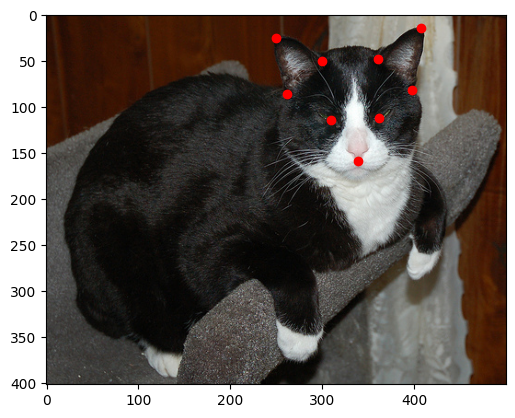

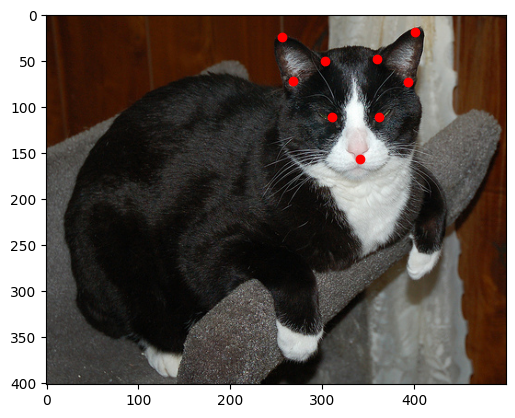

In [10]:
img, lbl, w, h = load_image('../input/cat-dataset/CAT_05/00001100_003.jpg')
image_preprocessed = preprocess_image(img)

bbox_pred, class_pred = model.predict(np.expand_dims(image_preprocessed, axis=0))
bbox_pred = decode_labels(bbox_pred.flatten(), w, h)

# Display ground truth and predicted results
show_results(img, lbl)  # Ground truth
show_results(img, bbox_pred)  # Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


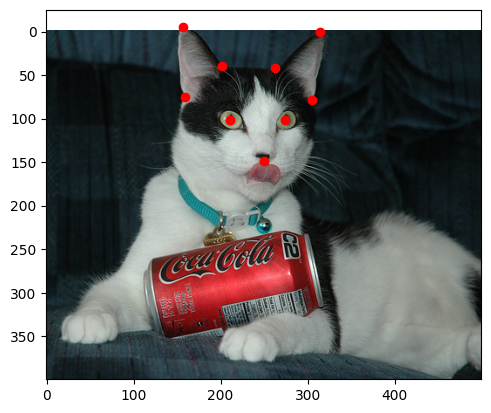

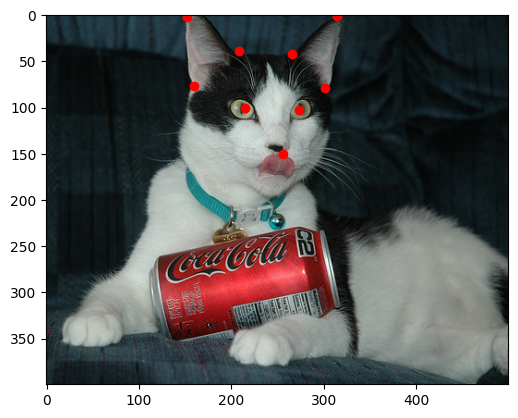

In [11]:
img, lbl, w, h = load_image('../input/cat-dataset/CAT_06/00001292_017.jpg')
image_preprocessed = preprocess_image(img)

bbox_pred, class_pred = model.predict(np.expand_dims(image_preprocessed, axis=0))
bbox_pred = decode_labels(bbox_pred.flatten(), w, h)

# Display ground truth and predicted results
show_results(img, lbl)  # Ground truth
show_results(img, bbox_pred)  # Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


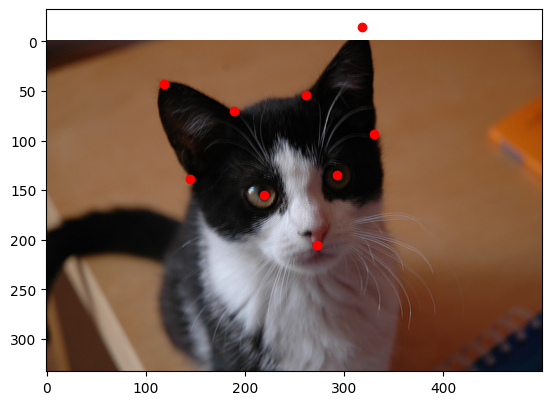

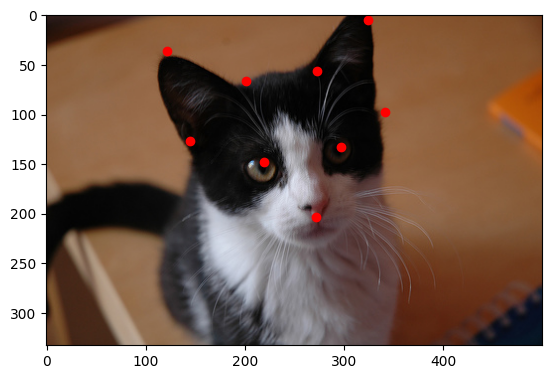

In [14]:
img, lbl, w, h = load_image('../input/cat-dataset/CAT_06/00001293_007.jpg')
image_preprocessed = preprocess_image(img)

# Predict using the model
bbox_pred, class_pred = model.predict(np.expand_dims(image_preprocessed, axis=0))
bbox_pred = decode_labels(bbox_pred.flatten(), w, h)

# Display ground truth and predicted results
show_results(img, lbl)  # Ground truth
show_results(img, bbox_pred)  # Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


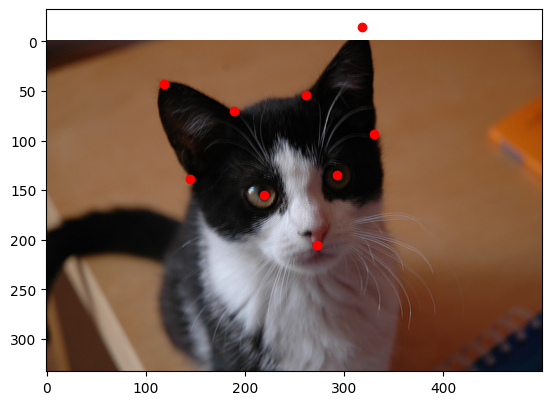

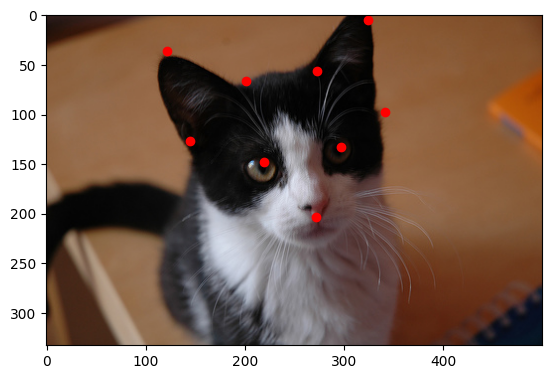

In [17]:
img, lbl, w, h = load_image('../input/cat-dataset/CAT_06/00001293_007.jpg')
image_preprocessed = preprocess_image(img)

bbox_pred, class_pred = model.predict(np.expand_dims(image_preprocessed, axis=0))
bbox_pred = decode_labels(bbox_pred.flatten(), w, h)

# Display ground truth and predicted results
show_results(img, lbl)  # Ground truth
show_results(img, bbox_pred)  # Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


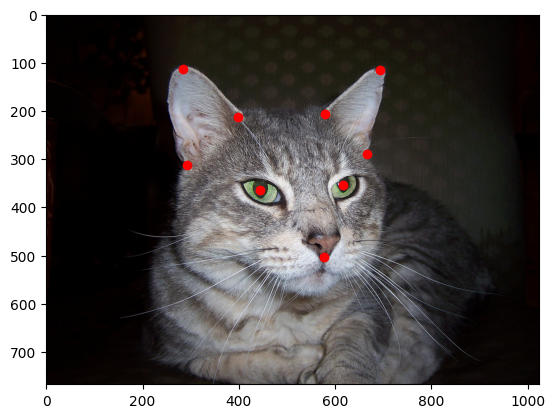

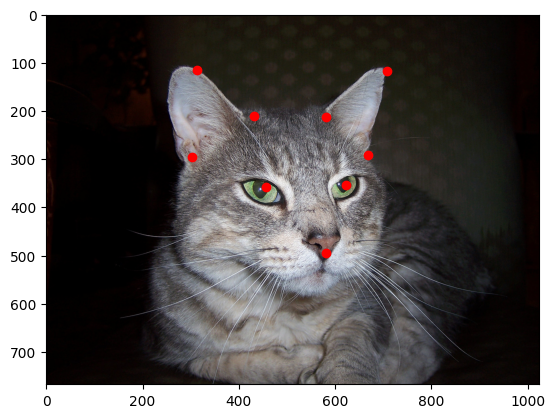

In [15]:
img, lbl, w, h = load_image('../input/cat-dataset/CAT_06/00001294_028.jpg')
image_preprocessed = preprocess_image(img)

bbox_pred, class_pred = model.predict(np.expand_dims(image_preprocessed, axis=0))
bbox_pred = decode_labels(bbox_pred.flatten(), w, h)

# Display ground truth and predicted results
show_results(img, lbl)  # Ground truth
show_results(img, bbox_pred)  # Predictions